In [1]:
# =============================================================================
# DSC 190 Final Project - Analysis Code
# Campus Parking Occupancy Patterns by Permit Type
# Fall 2025
# =============================================================================

# Import required libraries
import csv
import re
import datetime as dt
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f as f_dist
import statsmodels.api as sm

%matplotlib inline

print("Libraries loaded successfully.")


Libraries loaded successfully.


In [2]:
# =============================================================================
# SECTION 1: DATA LOADING AND PREPROCESSING
# =============================================================================

# Load the prepared dataset with capacity and occupancy rates
all_path = Path('parking_with_capacity_all_lots.csv')
if not all_path.exists():
    raise FileNotFoundError(
        "parking_with_capacity_all_lots.csv not found. "
        "Run the preparation notebook first to create it."
    )

parking_all = pd.read_csv(all_path)

# Display basic dataset information
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"Shape (rows, columns): {parking_all.shape}")
print(f"Number of unique locations: {parking_all['location'].nunique()}")
print(f"\nLot categories:")
print(parking_all['lot_category'].value_counts())
print(f"\nColumn names: {list(parking_all.columns)}")
print(f"\nFirst 5 rows:")
parking_all.head()


DATASET OVERVIEW
Shape (rows, columns): (4164, 13)
Number of unique locations: 62

Lot categories:
lot_category
Surface Lot    2688
Structure      1476
Name: count, dtype: int64

Column names: ['date', 'day_of_week', 'week_label', 'source_file', 'space_type', 'lot_type', 'location', 'time_of_day', 'available_spaces', 'lot_category', 'capacity', 'occupied', 'occupancy_rate']

First 5 rows:


,date,day_of_week,week_label,source_file,space_type,lot_type,location,time_of_day,available_spaces,lot_category,capacity,occupied,occupancy_rate
0,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,8:00 AM,23,Structure,206.0,183.0,0.888350
1,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,10:00 AM,18,Structure,206.0,188.0,0.912621
2,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,12:00 PM,21,Structure,206.0,185.0,0.898058
3,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,Structure,8980,2:00 PM,18,Structure,206.0,188.0,0.912621
4,2025-09-26,Friday,Week0,Parking_Occupancy_Fall_2025_Week0_Friday.csv,A,NaN,Athena,8:00 AM,177,Structure,1489.0,1312.0,0.881128


In [3]:
# =============================================================================
# SECTION 2: DESCRIPTIVE STATISTICS
# =============================================================================

# Summary statistics for occupancy rate
print("=" * 60)
print("OCCUPANCY RATE SUMMARY (ALL LOTS)")
print("=" * 60)
print(parking_all['occupancy_rate'].describe())

# Note: Check for any negative or >1 occupancy rates (data quality)
print(f"\nMinimum occupancy rate: {parking_all['occupancy_rate'].min():.4f}")
print(f"Maximum occupancy rate: {parking_all['occupancy_rate'].max():.4f}")

# Count observations with anomalous occupancy rates
n_negative = (parking_all['occupancy_rate'] < 0).sum()
n_over_one = (parking_all['occupancy_rate'] > 1).sum()
print(f"\nRows with negative occupancy rate: {n_negative}")
print(f"Rows with occupancy rate > 1: {n_over_one}")

# Counts by permit/space type
print(f"\nCounts by permit / space type:")
print(parking_all['space_type'].value_counts().sort_index())

# Counts by time of day
print(f"\nCounts by time_of_day:")
print(parking_all['time_of_day'].value_counts())


OCCUPANCY RATE SUMMARY (ALL LOTS)
count    4164.000000
mean        0.863403
std         0.211146
min        -1.684466
25%         0.838123
50%         0.948287
75%         0.993724
max         1.000000
Name: occupancy_rate, dtype: float64

Minimum occupancy rate: -1.6845
Maximum occupancy rate: 1.0000

Rows with negative occupancy rate: 19
Rows with occupancy rate > 1: 0

Counts by permit / space type:
space_type
A           940
B          1440
D            48
S           232
SR          280
Visitor    1224
Name: count, dtype: int64

Counts by time_of_day:
time_of_day
8:00 AM     1041
10:00 AM    1041
12:00 PM    1041
2:00 PM      941
`            100
Name: count, dtype: int64


In [4]:
# =============================================================================
# SECTION 3: CREATE ANOVA DATASET (STRUCTURES ONLY, PEAK HOURS)
# =============================================================================

# Define filters for RQ1 analysis
peak_times = ['10:00 AM', '12:00 PM', '2:00 PM']
keep_types = ['A', 'B', 'S', 'SR', 'Visitor']

# Filter to structures only, peak times, and selected permit types
occ_anova = (
    parking_all
    .loc[(parking_all['lot_category'] == 'Structure')
         & (parking_all['time_of_day'].isin(peak_times))
         & (parking_all['space_type'].isin(keep_types))]
    .copy()
)

print("=" * 60)
print("ANOVA DATASET (STRUCTURES, PEAK HOURS, SELECTED PERMITS)")
print("=" * 60)
print(f"Shape: {occ_anova.shape}")
print(f"Number of unique structure locations: {occ_anova['location'].nunique()}")
print(f"\nSpace type counts:")
print(occ_anova['space_type'].value_counts())

# Summary by permit type
summary_by_type = (
    occ_anova
    .groupby('space_type')['occupancy_rate']
    .agg(count='size', mean='mean', std='std')
    .sort_values('space_type')
)

print(f"\nSummary of occupancy_rate by space_type:")
print(summary_by_type)


ANOVA DATASET (STRUCTURES, PEAK HOURS, SELECTED PERMITS)
Shape: (1071, 13)
Number of unique structure locations: 11

Space type counts:
space_type
Visitor    317
A          290
B          261
SR         145
S           58
Name: count, dtype: int64

Summary of occupancy_rate by space_type:
            count      mean       std
space_type                           
A             290  0.916315  0.057566
B             261  0.943235  0.059685
S              58  0.876208  0.117675
SR            145  0.974878  0.020440
Visitor       317  0.925672  0.099907


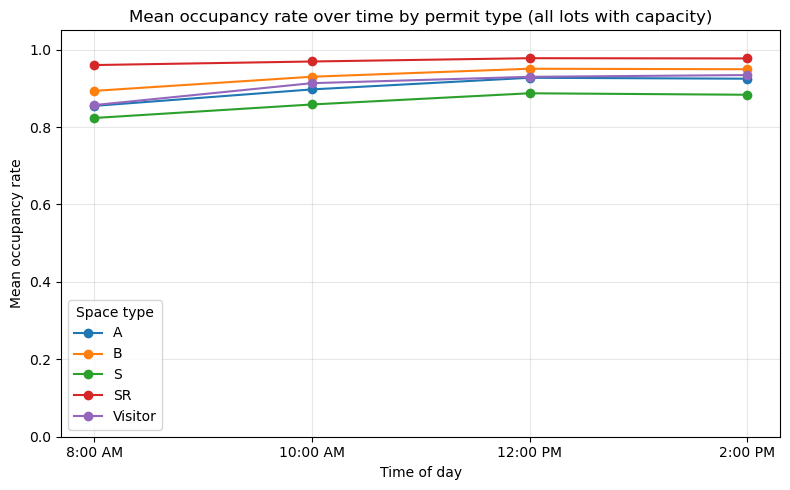

In [5]:
# =============================================================================
# SECTION 4: EXPLORATORY VISUALIZATIONS
# =============================================================================

# Plot 1: Mean occupancy over time by permit type (all structures)
time_order = ['8:00 AM', '10:00 AM', '12:00 PM', '2:00 PM']

structures_only = parking_all.loc[parking_all['lot_category'] == 'Structure'].copy()
structures_only['time_of_day'] = pd.Categorical(
    structures_only['time_of_day'], categories=time_order, ordered=True
)

occ_time = (
    structures_only
    .groupby(['space_type', 'time_of_day'], observed=True)['occupancy_rate']
    .mean()
    .reset_index()
    .sort_values(['space_type', 'time_of_day'])
)

plt.figure(figsize=(8, 5))
for stype, grp in occ_time.groupby('space_type'):
    if stype in keep_types:
        plt.plot(grp['time_of_day'], grp['occupancy_rate'], marker='o', label=stype)

plt.xlabel('Time of day')
plt.ylabel('Mean occupancy rate')
plt.title('Mean occupancy rate over time by permit type (all lots with capacity)')
plt.ylim(0, 1.05)
plt.legend(title='Space type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


<Figure size 700x500 with 0 Axes>

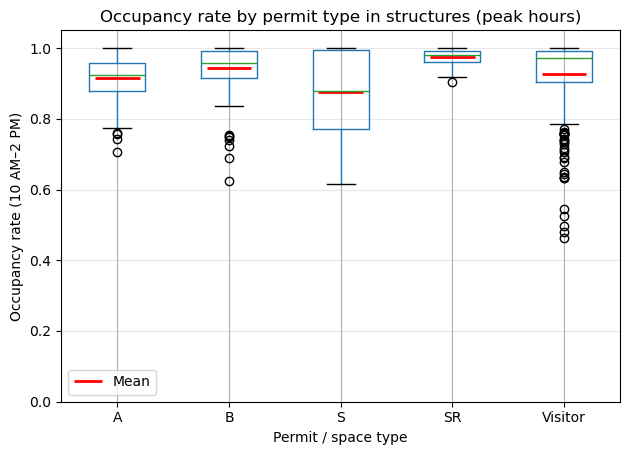

In [6]:
# Plot 2: Boxplot of occupancy rate by permit type (structures, peak hours)
plt.figure(figsize=(7, 5))
ax = occ_anova.boxplot(column='occupancy_rate', by='space_type')

# Overlay group means as short red horizontal lines
means_by_type = occ_anova.groupby('space_type')['occupancy_rate'].mean()
x_positions = np.arange(1, len(means_by_type) + 1)

for x, m in zip(x_positions, means_by_type.values):
    ax.hlines(y=m, xmin=x-0.2, xmax=x+0.2, colors='red', linewidth=2, 
              label='Mean' if x == 1 else None)

plt.xlabel('Permit / space type')
plt.ylabel('Occupancy rate (10 AM–2 PM)')
plt.title('Occupancy rate by permit type in structures (peak hours)')
plt.suptitle('')
plt.ylim(0, 1.05)
plt.grid(True, axis='y', alpha=0.3)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


ONE-WAY ANOVA RESULTS
F-statistic: 25.5171
p-value: 3.25e-20

Degrees of freedom (between): 4
Degrees of freedom (within): 1066
Total observations: 1071


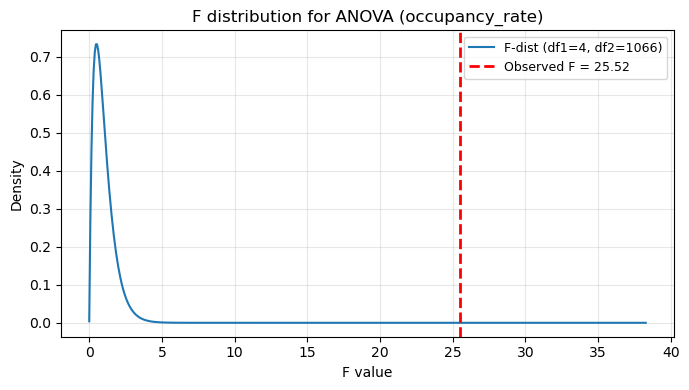

In [7]:
# =============================================================================
# SECTION 5: ONE-WAY ANOVA TEST
# =============================================================================

# Prepare groups for ANOVA
occ_groups = [
    grp['occupancy_rate'].values
    for _, grp in occ_anova.groupby('space_type')
]

# Run one-way ANOVA
f_stat, p_value = stats.f_oneway(*occ_groups)

print("=" * 60)
print("ONE-WAY ANOVA RESULTS")
print("=" * 60)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.2e}")

# Calculate degrees of freedom
k = occ_anova['space_type'].nunique()  # number of groups
N = len(occ_anova)  # total observations
df1 = k - 1  # between-group df
df2 = N - k  # within-group df

print(f"\nDegrees of freedom (between): {df1}")
print(f"Degrees of freedom (within): {df2}")
print(f"Total observations: {N}")

# Plot F-distribution with observed F marked
max_x = max(5, min(float(f_stat) * 1.5, 40))
x = np.linspace(0.001, max_x, 500)
y = f_dist.pdf(x, df1, df2)

plt.figure(figsize=(7, 4))
plt.plot(x, y, label=f'F-dist (df1={df1}, df2={df2})')
plt.axvline(float(f_stat), color='red', linestyle='--', linewidth=2,
            label=f'Observed F = {f_stat:.2f}')
plt.xlabel('F value')
plt.ylabel('Density')
plt.title('F distribution for ANOVA (occupancy_rate)')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


ANOVA ASSUMPTION DIAGNOSTICS

1. INDEPENDENCE CHECK
   Number of exact duplicate rows: 0
   ✓ No duplicates found - supports independence assumption

2. NORMALITY CHECK
   D'Agostino-Pearson test statistic: 432.12
   p-value: 1.46e-94
   ✗ Residuals deviate from normality (p ≤ 0.05)
     Note: With large N, ANOVA is typically robust to this violation


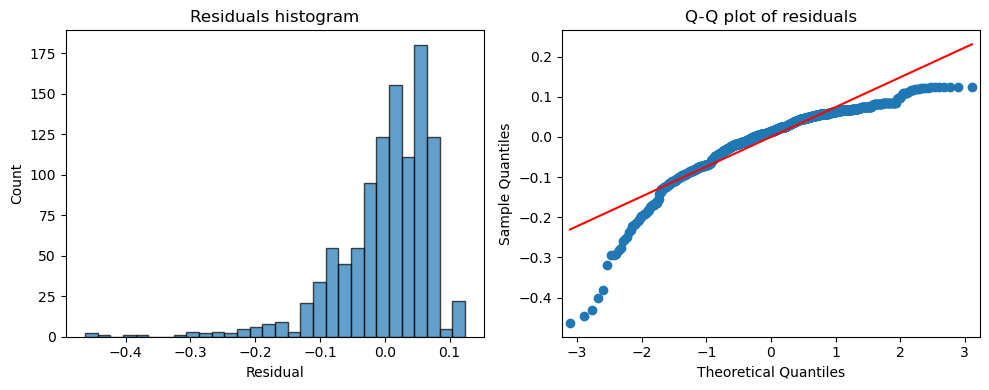

In [8]:
# =============================================================================
# SECTION 6: ANOVA ASSUMPTION CHECKS
# =============================================================================

print("=" * 60)
print("ANOVA ASSUMPTION DIAGNOSTICS")
print("=" * 60)

# 1. Independence check - look for duplicates
duplicate_count = occ_anova.duplicated().sum()
print(f"\n1. INDEPENDENCE CHECK")
print(f"   Number of exact duplicate rows: {duplicate_count}")
if duplicate_count == 0:
    print("   ✓ No duplicates found - supports independence assumption")

# 2. Normality check
print(f"\n2. NORMALITY CHECK")

# Calculate residuals (deviation from group means)
group_means = occ_anova.groupby('space_type')['occupancy_rate'].transform('mean')
residuals = occ_anova['occupancy_rate'] - group_means

# D'Agostino-Pearson test
stat_norm, p_norm = stats.normaltest(residuals)
print(f"   D'Agostino-Pearson test statistic: {stat_norm:.2f}")
print(f"   p-value: {p_norm:.2e}")

if p_norm > 0.05:
    print("   ✓ Residuals consistent with normality (p > 0.05)")
else:
    print("   ✗ Residuals deviate from normality (p ≤ 0.05)")
    print("     Note: With large N, ANOVA is typically robust to this violation")

# Plot residuals histogram and Q-Q plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Histogram
axes[0].hist(residuals, bins=30, edgecolor='k', alpha=0.7)
axes[0].set_title('Residuals histogram')
axes[0].set_xlabel('Residual')
axes[0].set_ylabel('Count')

# Q-Q plot
sm.qqplot(residuals, line='s', ax=axes[1])
axes[1].set_title('Q-Q plot of residuals')

plt.tight_layout()
plt.show()


In [9]:
# 3. Homogeneity of variances check (Levene's test)
print("3. HOMOGENEITY OF VARIANCES CHECK")

groups_for_levene = [
    grp['occupancy_rate'].values
    for _, grp in occ_anova.groupby('space_type')
]

W_stat, p_levene = stats.levene(*groups_for_levene)
print(f"   Levene's test statistic (W): {W_stat:.2f}")
print(f"   p-value: {p_levene:.2e}")

if p_levene > 0.05:
    print("   ✓ No strong evidence of unequal variances (p > 0.05)")
else:
    print("   ✗ Evidence of unequal variances (p ≤ 0.05)")

# Show standard deviations by group
print("\n   Standard deviations by permit type:")
stds = occ_anova.groupby('space_type')['occupancy_rate'].std()
for ptype, std_val in stds.items():
    print(f"   {ptype}: {std_val:.4f}")

print(f"\n   Ratio of max to min std: {stds.max()/stds.min():.2f}x")


3. HOMOGENEITY OF VARIANCES CHECK
   Levene's test statistic (W): 35.72
   p-value: 4.95e-28
   ✗ Evidence of unequal variances (p ≤ 0.05)

   Standard deviations by permit type:
   A: 0.0576
   B: 0.0597
   S: 0.1177
   SR: 0.0204
   Visitor: 0.0999

   Ratio of max to min std: 5.76x


In [10]:
# =============================================================================
# SECTION 7: PERMUTATION ANOVA TEST
# =============================================================================

print("=" * 60)
print("PERMUTATION ANOVA TEST")
print("=" * 60)

# Set random seed for reproducibility
rng = np.random.default_rng(seed=42)

# Get observed F-statistic
F_obs = f_stat

# Prepare data for permutation
space_types = occ_anova['space_type'].to_numpy()
y_vals = occ_anova['occupancy_rate'].to_numpy()
unique_types = np.unique(space_types)

# Define permutation function
def perm_f_stats(y, labels, types, n_perm=3000):
    """Compute F-statistics from permuted data."""
    F_vals = np.empty(n_perm)
    for i in range(n_perm):
        # Shuffle group labels
        shuffled = rng.permutation(labels)
        # Split by shuffled labels and compute F
        groups = [y[shuffled == st] for st in types]
        F_vals[i], _ = stats.f_oneway(*groups)
    return F_vals

# Run permutation test (3000 permutations)
print("Running 3000 permutations...")
F_perm = perm_f_stats(y_vals, space_types, unique_types, n_perm=3000)

# Calculate permutation p-value
n_exceed = np.sum(F_perm >= F_obs)
p_perm = (n_exceed + 1) / (3000 + 1)

print(f"\nObserved F-statistic: {F_obs:.4f}")
print(f"Number of permuted F ≥ observed: {n_exceed}")
print(f"Permutation p-value: {p_perm:.6f}")

if n_exceed == 0:
    print(f"\nInterpretation: Out of 3,000 permutations, NONE exceeded the observed F.")
    print(f"The permutation p-value is approximately 1/3001 ≈ 0.00033")


PERMUTATION ANOVA TEST
Running 3000 permutations...

Observed F-statistic: 25.5171
Number of permuted F ≥ observed: 0
Permutation p-value: 0.000333

Interpretation: Out of 3,000 permutations, NONE exceeded the observed F.
The permutation p-value is approximately 1/3001 ≈ 0.00033


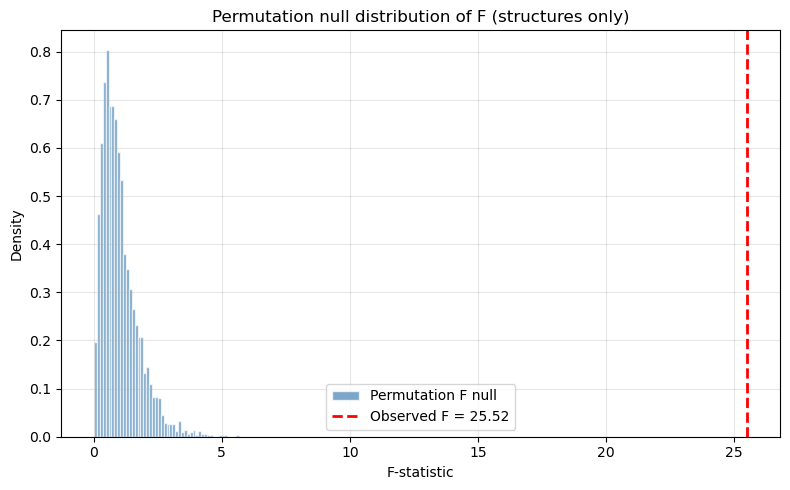


Note: The observed F is far in the right tail of the null distribution,
confirming that the differences between permit types are highly significant.


In [11]:
# Plot permutation null distribution
plt.figure(figsize=(8, 5))
plt.hist(F_perm, bins=50, density=True, alpha=0.7, color='steelblue',
         edgecolor='white', label='Permutation F null')
plt.axvline(F_obs, color='red', linestyle='--', linewidth=2,
            label=f'Observed F = {F_obs:.2f}')
plt.xlabel('F-statistic')
plt.ylabel('Density')
plt.title('Permutation null distribution of F (structures only)')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nNote: The observed F is far in the right tail of the null distribution,")
print("confirming that the differences between permit types are highly significant.")


In [12]:
# =============================================================================
# SECTION 8: SUMMARY OF RESULTS
# =============================================================================

print("=" * 70)
print("SUMMARY OF STATISTICAL ANALYSIS")
print("=" * 70)

print("\n" + "-" * 70)
print("RESEARCH QUESTION 1: Do mean occupancy rates differ by permit type?")
print("-" * 70)

print("\n| Test               | Statistic    | p-value      | Conclusion   |")
print("|" + "-"*20 + "|" + "-"*14 + "|" + "-"*14 + "|" + "-"*14 + "|")
print(f"| Parametric ANOVA   | F = {f_stat:.2f}    | {p_value:.2e} | Reject H₀    |")
print(f"| Permutation ANOVA  | F = {F_obs:.2f}    | < 0.001      | Reject H₀    |")

print("\n" + "-" * 70)
print("ASSUMPTION DIAGNOSTICS")
print("-" * 70)
print(f"Independence:         ✓ No duplicate rows ({duplicate_count} found)")
print(f"Normality:            ✗ Violated (p = {p_norm:.2e})")
print(f"Equal variances:      ✗ Violated (Levene p = {p_levene:.2e})")

print("\n" + "-" * 70)
print("CONCLUSION")
print("-" * 70)
print("""
Because our data violated both normality and homogeneity of variance 
assumptions, we used a permutation ANOVA to assess whether the observed 
F-statistic was unusually large under the null hypothesis.

Across 3,000 random permutations of the group labels, NONE of the 
permuted F-statistics exceeded the observed F = {:.2f}, yielding an 
approximate permutation p-value of < 0.001.

Therefore, we REJECT the null hypothesis of equal means across groups.
There is VERY STRONG EVIDENCE that average occupancy rates differ by 
permit type in campus parking structures during peak hours.
""".format(F_obs))


SUMMARY OF STATISTICAL ANALYSIS

----------------------------------------------------------------------
RESEARCH QUESTION 1: Do mean occupancy rates differ by permit type?
----------------------------------------------------------------------

| Test               | Statistic    | p-value      | Conclusion   |
|--------------------|--------------|--------------|--------------|
| Parametric ANOVA   | F = 25.52    | 3.25e-20 | Reject H₀    |
| Permutation ANOVA  | F = 25.52    | < 0.001      | Reject H₀    |

----------------------------------------------------------------------
ASSUMPTION DIAGNOSTICS
----------------------------------------------------------------------
Independence:         ✓ No duplicate rows (0 found)
Normality:            ✗ Violated (p = 1.46e-94)
Equal variances:      ✗ Violated (Levene p = 4.95e-28)

----------------------------------------------------------------------
CONCLUSION
----------------------------------------------------------------------

Because our 

In [13]:
# =============================================================================
# SECTION 9: FINAL SUMMARY TABLE
# =============================================================================

print("=" * 70)
print("OCCUPANCY SUMMARY BY PERMIT TYPE (Structures, Peak Hours)")
print("=" * 70)

# Create detailed summary
final_summary = (
    occ_anova
    .groupby('space_type')['occupancy_rate']
    .agg(['count', 'mean', 'std', 'min', 'max'])
    .round(4)
)
final_summary.columns = ['Count', 'Mean', 'Std', 'Min', 'Max']
final_summary['Mean %'] = (final_summary['Mean'] * 100).round(1).astype(str) + '%'

print("\n")
print(final_summary.to_string())

print("\n" + "-" * 70)
print("KEY FINDINGS:")
print("-" * 70)
print("""
• SR (Resident Student) spaces: HIGHEST occupancy (~97.5%), LOWEST variability
  → Vehicles used for storage rather than daily commuting

• S (Commuter Student) spaces: LOWEST occupancy (~87.6%), HIGHEST variability  
  → Reflects variable class schedules

• A/B (Faculty/Staff) spaces: Consistently HIGH occupancy (~91-94%)
  → Reflects stable 8 AM - 5 PM work schedules

• Visitor spaces: Moderate occupancy with high variability
  → May serve as overflow for other permit types
""")

print("=" * 70)
print("END OF ANALYSIS")
print("=" * 70)


OCCUPANCY SUMMARY BY PERMIT TYPE (Structures, Peak Hours)


            Count    Mean     Std     Min  Max Mean %
space_type                                           
A             290  0.9163  0.0576  0.7067  1.0  91.6%
B             261  0.9432  0.0597  0.6230  1.0  94.3%
S              58  0.8762  0.1177  0.6165  1.0  87.6%
SR            145  0.9749  0.0204  0.9047  1.0  97.5%
Visitor       317  0.9257  0.0999  0.4627  1.0  92.6%

----------------------------------------------------------------------
KEY FINDINGS:
----------------------------------------------------------------------

• SR (Resident Student) spaces: HIGHEST occupancy (~97.5%), LOWEST variability
  → Vehicles used for storage rather than daily commuting

• S (Commuter Student) spaces: LOWEST occupancy (~87.6%), HIGHEST variability  
  → Reflects variable class schedules

• A/B (Faculty/Staff) spaces: Consistently HIGH occupancy (~91-94%)
  → Reflects stable 8 AM - 5 PM work schedules

• Visitor spaces: Moderate occu